In [1]:
import sys
import os
sys.path.append('../..')
sys.path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from phm_framework.nets import dpm 
from phm_framework.data import prepare_data
from phm_framework.data import synthetic
from tqdm import tqdm

2024-12-29 11:15:45.410783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735467345.425614   23561 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735467345.430070   23561 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 11:15:45.444899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument 

In [3]:
meta_att = [f"att{i}" for i in range(10)]

dpm_model = dpm.DiffusionModel(128,
                     widths=[32, 64, 64, 32, 32, 32],
                     block_depth=3,
                     num_features=len(meta_att),
                     timesteps=20,
                     cond=True,
                     envelopes=True,
                     feature_names=meta_att,
                     feature_loss_net=False,
                     feature_loss=False)

dpm_model.network = tf.keras.models.load_model("../../../weights/CWRU_DPM_v1.h5",
                                         custom_objects = {"Gather": dpm.Gather,
                                                           "Swish": dpm.Swish})

I0000 00:00:1735428108.100566   10682 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10506 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [3]:
ds = datasets.Dataset("CWRU")
task = ds['fault']
sets = task[0]


X_train, M_train, Y_train = prepare_data(sets['train'], 'DE', subsignal_length=128, signal_max_length=20000)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)


X_val, M_val, Y_val = prepare_data(sets['val'], 'DE', subsignal_length=128, signal_max_length=20000)


Dataset CWRU already downloaded and extracted
Remember to cite the original publisher dataset:
	@misc{caseBearingData,
		author = {},
		title = {{B}earing {D}ata {C}enter | {C}ase {S}chool of {E}ngineering | {C}ase {W}estern {R}eserve {U}niversity --- engineering.case.edu},
		howpublished = {\url{https://engineering.case.edu/bearingdatacenter}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://engineering.case.edu/bearingdatacenter

** If you find this tool useful, please cite our SoftwareX paper.



Reading data: 100%|██████████| 161/161 [00:10<00:00, 15.68it/s]
INFO:root:Read in 14.165191888809204 seconds
INFO:root:It is possible stratified split? True
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: DE,fault,unit
INFO:root:Train shape: (28567988, 3)
INFO:root:Val shape: (7804030, 3)
INFO:root:Test shape: (979629, 3)
INFO:root:Meta-attributes extracted in 21.377182722091675 seconds
INFO:root:Meta-attributes extracted in 5.641324281692505 seconds


In [5]:
ds.describe()

CWRU

Description
In this renowned dataset, experiments were conducted utilizing a 2 HP Reliance Electric motor, where acceleration data was measured at locations both near to and remote from the motor bearings. Motor bearings were intentionally seeded with faults using electro-discharge machining (EDM). These faults ranged in diameter from 0.007 inches to 0.040 inches and were separately introduced at the inner raceway, rolling element (i.e., ball), and outer raceway of the bearings. After seeding, the faulted bearings were reinstalled into the test motor, and vibration data was recorded for motor loads ranging from 0 to 3 horsepower, corresponding to motor speeds between 1797 and 1720 RPM. The vibration data was sampled at a frequency of 12 kHz, with each vibration signal lasting for a duration of 10 seconds.

Designation: Bearing Fault Diagnostic
Publisher: Case Western Reserve University
Domain: Mechanical component
Application: Bearing
License: CC BY-SA 4.0

System info
1. type   

In [6]:
(X, E, M), (centroids, stds, kmeans) = synthetic.generate_synth_data(X_train, N=100000)    

/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [4]:
from phm_framework.nets import cnn
from importlib import reload
reload(cnn)

nclasses = len(np.unique(Y_train))
EPOCHS = 200

if os.path.exists('../../../weights/CWRU_fault_model.h5'):
    cwru_model = tf.keras.models.load_model("../../../weights/CWRU_fault_model.h5")
else:
    results, cwru_model = cnn.train((np.expand_dims(X_train, axis=-1), Y_train), 
                               nclasses, 
                               EPOCHS, 
                               es=False, 
                               validation_data=(np.expand_dims(X_val, axis=-1), Y_val))
    cwru_model.save('CWRU_fault_model.h5')




I0000 00:00:1735467480.592695   23561 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10506 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [32]:
Y_pred_classes

array([[2.7255607e-11, 1.0000000e+00, 2.8069415e-14, 8.6115634e-39],
       [9.3547236e-12, 1.0000000e+00, 4.8476880e-09, 7.9790764e-33],
       [4.6836113e-09, 9.9977404e-01, 2.2599525e-04, 7.8086336e-34],
       ...,
       [2.1405773e-27, 0.0000000e+00, 4.6683602e-26, 1.0000000e+00],
       [4.7412707e-37, 0.0000000e+00, 2.6153897e-25, 1.0000000e+00],
       [6.1394813e-13, 0.0000000e+00, 2.0523066e-21, 1.0000000e+00]],
      dtype=float32)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 800x600 with 0 Axes>

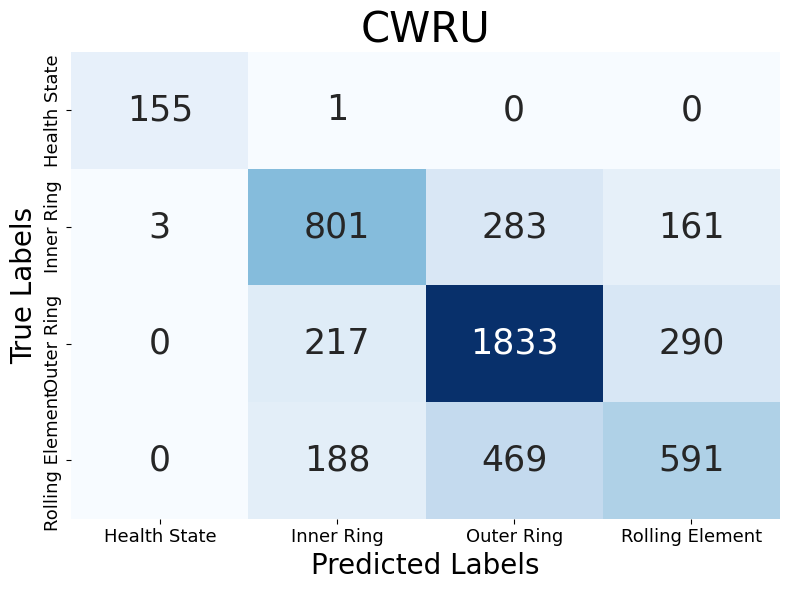

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model and get predictions
Y_pred = cwru_model.predict(X_val)
Y_pred_classes = Y_pred.argmax(axis=1)  # Get the predicted class index
Y_true = Y_val   # Get the true class index

Y_true = (Y_true + 1) % 4
Y_pred_classes = (Y_pred_classes + 1) % 4


# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Define class labels (replace with your actual class names)
class_labels = ["Health State", "Inner Ring", "Outer Ring", "Rolling Element"]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels,
           annot_kws={"size": 25}, cbar=False)
plt.xlabel('Predicted Labels', fontsize=20)
plt.ylabel('True Labels', fontsize=20)
plt.title('CWRU', fontsize = 30)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.tight_layout()
plt.savefig('cm_cwru.pdf')

/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)


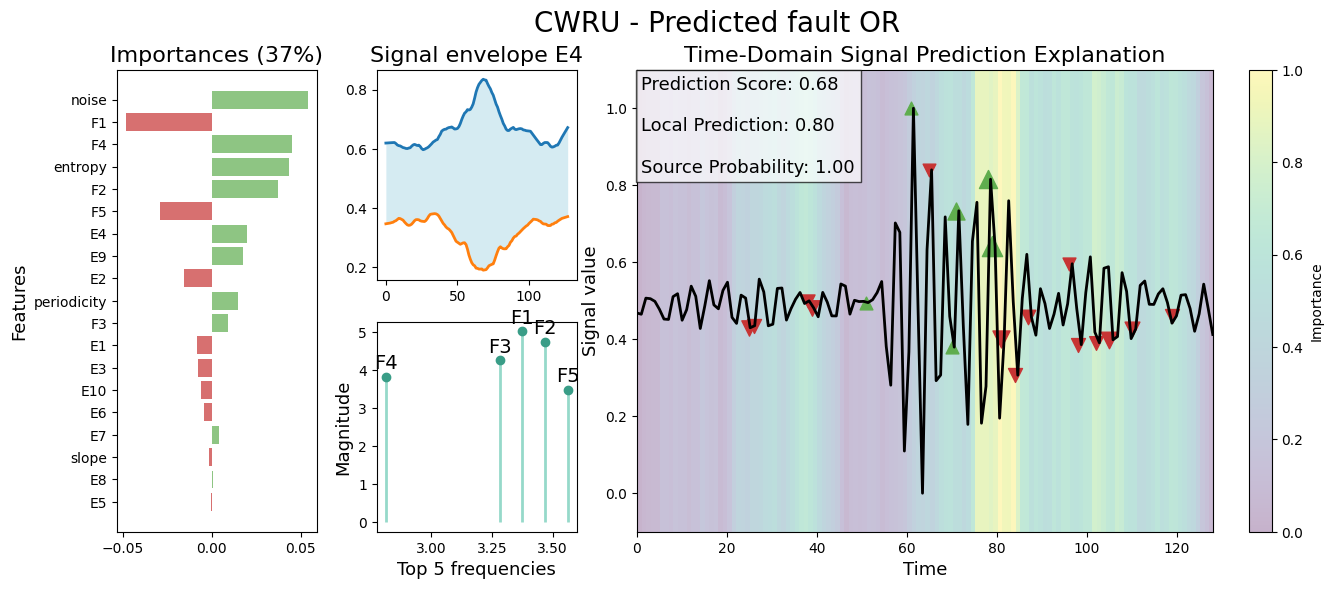

In [252]:
from phm_framework.xai import lime
from phm_framework.data import meta, synthetic
from phm_framework.xai import plot
from importlib import reload
reload(plot)

difflime = lime.DiffLIME(cwru_model, dpm_model, centroids, nsamples=100, verbose=False)

_, explanation, prediction_score, local_pred, source_prob, source_klass = difflime.explain(X_val[0])


plot.plot_importances(X_val[0], explanation, prediction_score, local_pred, 
                 source_prob, centroids, title=f"CWRU - Predicted fault {task.meta['target_labels'][source_klass]}", 
                 topi=20, base_frec=12)
plt.savefig("imp.svg")

Generate explanation of the samples in the validation set.

In [ ]:
import pickle as pk
import tqdm 
import gc
from phm_framework.xai import lime
from phm_framework.xai import plot

indexes = np.arange(0, X_val.shape[0])
np.random.shuffle(indexes)

for i in tqdm.tqdm(indexes):
    try:
        difflime = lime.DiffLIME(cwru_model, dpm_model, centroids, nsamples=200, verbose=False)
        (_, explanation, prediction_score, local_pred, 
         source_prob, source_klass) = difflime.explain(X_val[i])
        plot.plot_importances(X_val[i], explanation, prediction_score, local_pred, 
                         source_prob, centroids, 
                         title=f"CWRU - Predicted fault {task.meta['target_labels'][source_klass]}", 
                         topi=20, base_frec=12)
        plt.savefig(f"CWRU/S{i}_k{int(Y_val[i][0])}_p{source_klass}.svg")
        plt.savefig(f"CWRU/S{i}_k{int(Y_val[i][0])}_p{source_klass}.png")
        plt.cla()
        exp =(explanation, prediction_score, local_pred,  source_prob, source_klass)
        file = open(f"CWRU/S{i}_k{int(Y_val[i][0])}_p{source_klass}.pk", "wb")
        pk.dump(exp, file)
        file.close()
        del difflime
        gc.collect()
    except:
        pass

  0%|          | 0/4992 [00:00<?, ?it/s]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  0%|          | 1/4992 [00:04<5:55:49,  4.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/das

  0%|          | 13/4992 [00:53<5:46:10,  4.17s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  0%|          | 14/4992 [00:57<5:40:19,  4.10s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right

  1%|          | 25/4992 [01:45<5:47:16,  4.19s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 26/4992 [01:50<6:06:56,  4.43s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right

  1%|          | 38/4992 [02:45<6:29:46,  4.72s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 39/4992 [02:49<6:18:01,  4.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right

  1%|          | 51/4992 [03:40<6:03:00,  4.41s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 52/4992 [03:44<5:51:03,  4.26s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right

  1%|▏         | 64/4992 [04:35<5:40:26,  4.15s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|▏         | 65/4992 [04:40<5:51:06,  4.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right

  2%|▏         | 77/4992 [05:33<5:48:03,  4.25s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 78/4992 [05:38<5:55:24,  4.34s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right

  2%|▏         | 90/4992 [06:31<6:05:04,  4.47s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 91/4992 [06:36<6:05:39,  4.48s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right

  2%|▏         | 103/4992 [07:30<6:15:44,  4.61s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 104/4992 [07:34<6:07:08,  4.51s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  2%|▏         | 116/4992 [08:26<5:51:30,  4.33s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 117/4992 [08:31<6:08:26,  4.53s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  3%|▎         | 129/4992 [09:24<5:58:50,  4.43s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 130/4992 [09:29<6:09:06,  4.56s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  3%|▎         | 142/4992 [10:23<5:41:06,  4.22s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 143/4992 [10:27<5:47:17,  4.30s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  3%|▎         | 155/4992 [11:22<5:49:44,  4.34s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 156/4992 [11:26<5:47:55,  4.32s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  3%|▎         | 168/4992 [12:17<5:50:41,  4.36s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 169/4992 [12:21<5:23:10,  4.02s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  4%|▎         | 181/4992 [13:10<5:41:45,  4.26s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  4%|▎         | 182/4992 [13:14<5:36:56,  4.20s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  4%|▍         | 194/4992 [14:06<5:58:47,  4.49s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  4%|▍         | 195/4992 [14:11<6:09:44,  4.62s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  4%|▍         | 207/4992 [15:00<5:05:12,  3.83s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  4%|▍         | 208/4992 [15:04<5:04:49,  3.82s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  4%|▍         | 220/4992 [15:46<4:38:00,  3.50s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  4%|▍         | 221/4992 [15:49<4:37:39,  3.49s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  5%|▍         | 233/4992 [16:34<4:51:28,  3.67s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  5%|▍         | 234/4992 [16:38<4:47:52,  3.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  5%|▍         | 246/4992 [17:21<4:49:14,  3.66s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  5%|▍         | 247/4992 [17:25<4:49:12,  3.66s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  5%|▌         | 259/4992 [18:09<4:46:48,  3.64s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  5%|▌         | 260/4992 [18:12<4:46:10,  3.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  5%|▌         | 272/4992 [18:56<4:42:49,  3.60s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  5%|▌         | 273/4992 [19:00<4:44:30,  3.62s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  6%|▌         | 285/4992 [19:45<5:01:02,  3.84s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  6%|▌         | 286/4992 [19:49<5:04:52,  3.89s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  6%|▌         | 298/4992 [20:35<4:57:40,  3.80s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  6%|▌         | 299/4992 [20:38<4:53:36,  3.75s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  6%|▌         | 311/4992 [21:26<5:05:52,  3.92s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  6%|▋         | 312/4992 [21:30<5:17:56,  4.08s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  6%|▋         | 324/4992 [22:16<4:59:48,  3.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  7%|▋         | 325/4992 [22:20<5:03:19,  3.90s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  7%|▋         | 337/4992 [23:08<5:24:17,  4.18s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  7%|▋         | 338/4992 [23:12<5:17:47,  4.10s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  7%|▋         | 350/4992 [23:58<4:55:55,  3.82s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  7%|▋         | 351/4992 [24:02<4:57:11,  3.84s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  7%|▋         | 363/4992 [24:51<5:12:22,  4.05s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  7%|▋         | 364/4992 [24:54<5:04:22,  3.95s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  8%|▊         | 376/4992 [25:42<5:09:18,  4.02s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  8%|▊         | 377/4992 [25:46<5:03:09,  3.94s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  8%|▊         | 389/4992 [26:36<5:12:22,  4.07s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  8%|▊         | 390/4992 [26:39<5:06:03,  3.99s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  8%|▊         | 402/4992 [27:28<5:12:14,  4.08s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  8%|▊         | 403/4992 [27:33<5:18:37,  4.17s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  8%|▊         | 415/4992 [28:22<5:09:19,  4.06s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  8%|▊         | 416/4992 [28:27<5:11:20,  4.08s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  9%|▊         | 428/4992 [29:17<5:24:06,  4.26s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  9%|▊         | 429/4992 [29:22<5:34:42,  4.40s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  9%|▉         | 441/4992 [30:13<5:36:23,  4.44s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  9%|▉         | 442/4992 [30:18<5:32:55,  4.39s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  9%|▉         | 454/4992 [31:08<5:20:21,  4.24s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  9%|▉         | 455/4992 [31:13<5:24:32,  4.29s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

  9%|▉         | 467/4992 [32:04<5:23:29,  4.29s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  9%|▉         | 468/4992 [32:09<5:36:10,  4.46s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 10%|▉         | 480/4992 [33:03<5:32:24,  4.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 10%|▉         | 481/4992 [33:07<5:28:05,  4.36s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 10%|▉         | 493/4992 [33:59<5:36:10,  4.48s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 10%|▉         | 494/4992 [34:04<5:27:47,  4.37s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 10%|█         | 506/4992 [34:56<5:22:41,  4.32s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 10%|█         | 507/4992 [35:00<5:22:49,  4.32s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 10%|█         | 519/4992 [35:52<5:18:27,  4.27s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 10%|█         | 520/4992 [35:57<5:18:30,  4.27s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 11%|█         | 532/4992 [36:51<5:41:10,  4.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 11%|█         | 533/4992 [36:55<5:35:52,  4.52s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 11%|█         | 545/4992 [37:50<5:40:28,  4.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 11%|█         | 546/4992 [37:55<5:50:43,  4.73s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 11%|█         | 558/4992 [38:50<5:38:37,  4.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 11%|█         | 559/4992 [38:55<5:44:05,  4.66s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 11%|█▏        | 571/4992 [39:50<5:38:24,  4.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 11%|█▏        | 572/4992 [39:54<5:43:15,  4.66s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 12%|█▏        | 584/4992 [40:51<5:54:12,  4.82s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 12%|█▏        | 585/4992 [40:55<5:43:58,  4.68s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 12%|█▏        | 597/4992 [41:51<5:50:08,  4.78s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 12%|█▏        | 598/4992 [41:56<5:55:28,  4.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 12%|█▏        | 610/4992 [42:53<5:47:51,  4.76s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 12%|█▏        | 611/4992 [42:57<5:42:28,  4.69s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 12%|█▏        | 623/4992 [43:54<5:47:36,  4.77s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 12%|█▎        | 624/4992 [43:59<5:52:53,  4.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 13%|█▎        | 636/4992 [44:58<5:59:11,  4.95s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 13%|█▎        | 637/4992 [45:02<5:49:10,  4.81s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 13%|█▎        | 649/4992 [46:00<5:39:04,  4.68s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 13%|█▎        | 650/4992 [46:05<5:39:43,  4.69s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 13%|█▎        | 662/4992 [47:04<6:03:36,  5.04s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 13%|█▎        | 663/4992 [47:08<5:56:23,  4.94s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 14%|█▎        | 675/4992 [48:08<5:54:43,  4.93s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 14%|█▎        | 676/4992 [48:13<5:44:25,  4.79s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 14%|█▍        | 688/4992 [49:11<5:44:24,  4.80s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 14%|█▍        | 689/4992 [49:16<5:41:08,  4.76s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 14%|█▍        | 701/4992 [50:15<5:49:00,  4.88s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 14%|█▍        | 702/4992 [50:20<5:47:57,  4.87s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 14%|█▍        | 714/4992 [51:21<6:20:40,  5.34s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 14%|█▍        | 715/4992 [51:26<6:16:29,  5.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 15%|█▍        | 727/4992 [52:25<5:47:45,  4.89s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 15%|█▍        | 728/4992 [52:30<5:47:39,  4.89s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 15%|█▍        | 740/4992 [53:31<5:50:27,  4.95s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 15%|█▍        | 741/4992 [53:35<5:49:52,  4.94s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 15%|█▌        | 753/4992 [54:36<5:59:12,  5.08s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 15%|█▌        | 754/4992 [54:42<6:02:36,  5.13s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 15%|█▌        | 766/4992 [55:43<6:07:03,  5.21s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 15%|█▌        | 767/4992 [55:49<6:16:58,  5.35s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 16%|█▌        | 779/4992 [56:50<6:00:19,  5.13s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 16%|█▌        | 780/4992 [56:55<6:01:10,  5.15s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 16%|█▌        | 792/4992 [57:58<6:05:41,  5.22s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 16%|█▌        | 793/4992 [58:03<6:11:16,  5.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 16%|█▌        | 805/4992 [59:08<6:09:21,  5.29s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 16%|█▌        | 806/4992 [59:13<6:11:33,  5.33s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper rig

 16%|█▋        | 818/4992 [1:00:17<6:12:57,  5.36s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 16%|█▋        | 819/4992 [1:00:22<6:10:28,  5.33s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 17%|█▋        | 831/4992 [1:01:26<6:11:11,  5.35s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 17%|█▋        | 832/4992 [1:01:31<6:05:48,  5.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 17%|█▋        | 844/4992 [1:02:36<6:14:43,  5.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 17%|█▋        | 845/4992 [1:02:41<6:12:31,  5.39s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 17%|█▋        | 857/4992 [1:03:45<6:03:39,  5.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 17%|█▋        | 858/4992 [1:03:51<6:07:41,  5.34s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 17%|█▋        | 870/4992 [1:04:57<6:15:26,  5.47s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 17%|█▋        | 871/4992 [1:05:02<6:10:58,  5.40s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 18%|█▊        | 883/4992 [1:06:08<6:21:20,  5.57s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 18%|█▊        | 884/4992 [1:06:13<6:19:14,  5.54s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 18%|█▊        | 896/4992 [1:07:19<6:16:30,  5.52s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 18%|█▊        | 897/4992 [1:07:24<6:11:52,  5.45s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 18%|█▊        | 909/4992 [1:08:33<6:34:29,  5.80s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 18%|█▊        | 910/4992 [1:08:39<6:34:03,  5.79s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 18%|█▊        | 922/4992 [1:09:45<6:18:49,  5.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 18%|█▊        | 923/4992 [1:09:51<6:15:54,  5.54s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 19%|█▊        | 935/4992 [1:10:58<6:18:08,  5.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 19%|█▉        | 936/4992 [1:11:03<6:16:28,  5.57s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 19%|█▉        | 948/4992 [1:12:12<6:24:09,  5.70s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 19%|█▉        | 949/4992 [1:12:17<6:19:12,  5.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 19%|█▉        | 961/4992 [1:13:26<6:32:41,  5.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 19%|█▉        | 962/4992 [1:13:32<6:28:42,  5.79s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 20%|█▉        | 974/4992 [1:14:39<6:15:49,  5.61s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 20%|█▉        | 975/4992 [1:14:46<6:31:21,  5.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 20%|█▉        | 987/4992 [1:15:54<6:14:04,  5.60s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 20%|█▉        | 988/4992 [1:16:00<6:09:38,  5.54s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

 20%|██        | 1000/4992 [1:17:10<6:30:58,  5.88s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 20%|██        | 1001/4992 [1:17:15<6:24:45,  5.78s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 20%|██        | 1013/4992 [1:18:20<5:50:59,  5.29s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 20%|██        | 1014/4992 [1:18:26<6:06:25,  5.53s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 21%|██        | 1026/4992 [1:19:38<6:45:45,  6.14s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 21%|██        | 1027/4992 [1:19:44<6:44:41,  6.12s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 21%|██        | 1039/4992 [1:20:54<6:27:46,  5.89s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 21%|██        | 1040/4992 [1:21:00<6:33:52,  5.98s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 21%|██        | 1052/4992 [1:22:13<6:31:58,  5.97s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 21%|██        | 1053/4992 [1:22:18<6:25:17,  5.87s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 21%|██▏       | 1065/4992 [1:23:30<6:51:06,  6.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 21%|██▏       | 1066/4992 [1:23:38<7:19:50,  6.72s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 22%|██▏       | 1078/4992 [1:25:09<8:07:48,  7.48s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 22%|██▏       | 1079/4992 [1:25:17<8:05:13,  7.44s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 22%|██▏       | 1091/4992 [1:26:46<7:54:45,  7.30s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 22%|██▏       | 1092/4992 [1:26:54<8:05:21,  7.47s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 22%|██▏       | 1104/4992 [1:28:21<8:05:08,  7.49s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 22%|██▏       | 1105/4992 [1:28:29<8:17:46,  7.68s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 22%|██▏       | 1117/4992 [1:30:05<8:31:40,  7.92s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 22%|██▏       | 1118/4992 [1:30:12<8:14:52,  7.66s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 23%|██▎       | 1130/4992 [1:31:45<8:15:14,  7.69s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 23%|██▎       | 1131/4992 [1:31:52<8:07:45,  7.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 23%|██▎       | 1143/4992 [1:33:26<8:10:52,  7.65s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 23%|██▎       | 1144/4992 [1:33:34<8:09:38,  7.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 23%|██▎       | 1156/4992 [1:35:08<8:16:22,  7.76s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 23%|██▎       | 1157/4992 [1:35:16<8:25:13,  7.90s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 23%|██▎       | 1169/4992 [1:36:51<8:30:25,  8.01s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 23%|██▎       | 1170/4992 [1:36:59<8:31:24,  8.03s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 24%|██▎       | 1182/4992 [1:38:34<8:25:25,  7.96s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 24%|██▎       | 1183/4992 [1:38:42<8:24:27,  7.95s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 24%|██▍       | 1195/4992 [1:40:15<8:13:25,  7.80s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 24%|██▍       | 1196/4992 [1:40:23<8:19:38,  7.90s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 24%|██▍       | 1208/4992 [1:41:53<7:50:12,  7.46s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 24%|██▍       | 1209/4992 [1:42:01<8:00:23,  7.62s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 24%|██▍       | 1221/4992 [1:43:35<8:18:14,  7.93s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 24%|██▍       | 1222/4992 [1:43:43<8:33:59,  8.18s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 25%|██▍       | 1234/4992 [1:45:15<8:13:09,  7.87s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 25%|██▍       | 1235/4992 [1:45:22<8:03:42,  7.72s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 25%|██▍       | 1247/4992 [1:46:58<8:11:56,  7.88s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 25%|██▌       | 1248/4992 [1:47:06<8:21:26,  8.04s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 25%|██▌       | 1260/4992 [1:48:44<8:28:22,  8.17s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 25%|██▌       | 1261/4992 [1:48:51<8:09:54,  7.88s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 26%|██▌       | 1273/4992 [1:50:30<8:19:40,  8.06s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 26%|██▌       | 1274/4992 [1:50:38<8:24:25,  8.14s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 26%|██▌       | 1286/4992 [1:52:15<8:16:12,  8.03s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 26%|██▌       | 1287/4992 [1:52:22<7:51:55,  7.64s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 26%|██▌       | 1299/4992 [1:54:00<8:17:44,  8.09s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 26%|██▌       | 1300/4992 [1:54:08<8:32:34,  8.33s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 26%|██▋       | 1312/4992 [1:55:47<8:26:01,  8.25s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 26%|██▋       | 1313/4992 [1:55:55<8:18:08,  8.12s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 27%|██▋       | 1325/4992 [1:57:33<8:13:25,  8.07s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 27%|██▋       | 1326/4992 [1:57:42<8:27:42,  8.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 27%|██▋       | 1338/4992 [1:59:23<8:40:52,  8.55s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 27%|██▋       | 1339/4992 [1:59:32<8:40:05,  8.54s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 27%|██▋       | 1351/4992 [2:01:12<8:27:34,  8.36s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 27%|██▋       | 1352/4992 [2:01:20<8:31:44,  8.44s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 27%|██▋       | 1364/4992 [2:03:01<8:39:21,  8.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 27%|██▋       | 1365/4992 [2:03:10<8:34:04,  8.50s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 28%|██▊       | 1377/4992 [2:04:52<8:15:12,  8.22s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 28%|██▊       | 1378/4992 [2:05:00<8:14:32,  8.21s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 28%|██▊       | 1390/4992 [2:06:44<8:28:14,  8.47s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 28%|██▊       | 1391/4992 [2:06:51<8:04:58,  8.08s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 28%|██▊       | 1403/4992 [2:08:33<8:05:32,  8.12s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 28%|██▊       | 1404/4992 [2:08:42<8:18:04,  8.33s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 28%|██▊       | 1416/4992 [2:10:23<8:16:03,  8.32s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 28%|██▊       | 1417/4992 [2:10:32<8:23:25,  8.45s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 29%|██▊       | 1429/4992 [2:12:16<8:37:14,  8.71s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 29%|██▊       | 1430/4992 [2:12:25<8:40:32,  8.77s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 29%|██▉       | 1456/4992 [2:16:02<8:24:37,  8.56s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 29%|██▉       | 1457/4992 [2:16:11<8:28:32,  8.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 29%|██▉       | 1469/4992 [2:17:55<8:23:14,  8.57s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 29%|██▉       | 1470/4992 [2:18:04<8:29:16,  8.68s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 30%|██▉       | 1482/4992 [2:19:48<8:29:45,  8.71s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 30%|██▉       | 1483/4992 [2:19:58<8:42:40,  8.94s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 30%|██▉       | 1495/4992 [2:21:44<8:36:23,  8.86s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 30%|██▉       | 1496/4992 [2:21:53<8:33:11,  8.81s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 30%|███       | 1508/4992 [2:23:37<8:26:13,  8.72s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 30%|███       | 1509/4992 [2:23:46<8:35:00,  8.87s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 30%|███       | 1521/4992 [2:25:31<8:24:23,  8.72s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 30%|███       | 1522/4992 [2:25:40<8:27:27,  8.77s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 31%|███       | 1534/4992 [2:27:25<8:22:42,  8.72s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 31%|███       | 1535/4992 [2:27:34<8:27:54,  8.82s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 31%|███       | 1547/4992 [2:29:19<8:22:17,  8.75s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 31%|███       | 1548/4992 [2:29:29<8:37:43,  9.02s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 31%|███▏      | 1560/4992 [2:31:17<8:32:17,  8.96s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 31%|███▏      | 1561/4992 [2:31:27<8:40:44,  9.11s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 32%|███▏      | 1573/4992 [2:33:15<8:40:06,  9.13s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 32%|███▏      | 1574/4992 [2:33:24<8:28:13,  8.92s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 32%|███▏      | 1586/4992 [2:35:12<8:41:48,  9.19s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 32%|███▏      | 1587/4992 [2:35:21<8:37:31,  9.12s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 32%|███▏      | 1599/4992 [2:37:07<8:23:31,  8.90s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 32%|███▏      | 1600/4992 [2:37:17<8:29:42,  9.02s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 32%|███▏      | 1612/4992 [2:39:07<8:36:08,  9.16s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 32%|███▏      | 1613/4992 [2:39:17<8:39:56,  9.23s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 33%|███▎      | 1625/4992 [2:41:05<8:34:17,  9.16s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 33%|███▎      | 1626/4992 [2:41:14<8:26:33,  9.03s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 33%|███▎      | 1638/4992 [2:43:07<9:07:17,  9.79s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 33%|███▎      | 1639/4992 [2:43:18<9:37:15, 10.33s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 33%|███▎      | 1651/4992 [2:45:25<9:34:42, 10.32s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 33%|███▎      | 1652/4992 [2:45:36<9:36:49, 10.36s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 33%|███▎      | 1664/4992 [2:47:29<8:24:00,  9.09s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 33%|███▎      | 1665/4992 [2:47:38<8:19:07,  9.00s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 34%|███▎      | 1677/4992 [2:49:27<8:25:52,  9.16s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 34%|███▎      | 1678/4992 [2:49:35<8:06:03,  8.80s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 34%|███▍      | 1690/4992 [2:51:28<8:37:31,  9.40s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 34%|███▍      | 1691/4992 [2:51:37<8:40:48,  9.47s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 34%|███▍      | 1703/4992 [2:53:30<8:42:11,  9.53s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 34%|███▍      | 1704/4992 [2:53:40<8:38:49,  9.47s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 34%|███▍      | 1716/4992 [2:55:31<8:07:49,  8.93s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 34%|███▍      | 1717/4992 [2:55:41<8:16:31,  9.10s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 35%|███▍      | 1729/4992 [2:57:34<8:11:43,  9.04s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 35%|███▍      | 1730/4992 [2:57:43<8:16:55,  9.14s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 35%|███▍      | 1742/4992 [2:59:37<8:36:14,  9.53s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 35%|███▍      | 1743/4992 [2:59:46<8:34:06,  9.49s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 35%|███▌      | 1755/4992 [3:01:42<8:27:19,  9.40s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 35%|███▌      | 1756/4992 [3:01:52<8:35:35,  9.56s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 35%|███▌      | 1768/4992 [3:03:45<8:30:18,  9.50s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 35%|███▌      | 1769/4992 [3:03:54<8:23:16,  9.37s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 36%|███▌      | 1781/4992 [3:05:50<8:37:19,  9.67s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 36%|███▌      | 1782/4992 [3:06:01<8:50:13,  9.91s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 36%|███▌      | 1794/4992 [3:07:58<8:47:20,  9.89s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 36%|███▌      | 1795/4992 [3:08:08<8:44:05,  9.84s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 36%|███▌      | 1807/4992 [3:10:02<8:14:50,  9.32s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 36%|███▌      | 1808/4992 [3:10:11<8:00:40,  9.06s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 36%|███▋      | 1820/4992 [3:12:08<8:33:31,  9.71s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 36%|███▋      | 1821/4992 [3:12:18<8:44:13,  9.92s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 37%|███▋      | 1833/4992 [3:14:16<8:31:57,  9.72s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 37%|███▋      | 1834/4992 [3:14:26<8:37:15,  9.83s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 37%|███▋      | 1846/4992 [3:16:25<8:36:43,  9.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 37%|███▋      | 1847/4992 [3:16:35<8:44:02, 10.00s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 37%|███▋      | 1859/4992 [3:18:32<8:44:55, 10.05s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 37%|███▋      | 1860/4992 [3:18:42<8:43:57, 10.04s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 38%|███▊      | 1872/4992 [3:20:42<8:38:05,  9.96s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 38%|███▊      | 1873/4992 [3:20:52<8:49:48, 10.19s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 38%|███▊      | 1885/4992 [3:22:52<8:38:24, 10.01s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 38%|███▊      | 1886/4992 [3:23:02<8:39:07, 10.03s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 38%|███▊      | 1898/4992 [3:25:01<8:25:23,  9.80s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 38%|███▊      | 1899/4992 [3:25:11<8:29:20,  9.88s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 38%|███▊      | 1911/4992 [3:27:11<8:32:09,  9.97s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 38%|███▊      | 1912/4992 [3:27:21<8:43:52, 10.21s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 39%|███▊      | 1924/4992 [3:29:22<8:30:12,  9.98s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 39%|███▊      | 1925/4992 [3:29:32<8:30:53,  9.99s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 39%|███▉      | 1937/4992 [3:31:32<8:28:40,  9.99s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 39%|███▉      | 1938/4992 [3:31:42<8:39:12, 10.20s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 39%|███▉      | 1950/4992 [3:33:43<8:36:22, 10.18s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 39%|███▉      | 1951/4992 [3:33:54<8:48:00, 10.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 39%|███▉      | 1963/4992 [3:35:57<8:40:28, 10.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 39%|███▉      | 1964/4992 [3:36:08<8:48:07, 10.46s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 40%|███▉      | 1976/4992 [3:38:11<8:37:29, 10.30s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 40%|███▉      | 1977/4992 [3:38:21<8:28:48, 10.13s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 40%|███▉      | 1989/4992 [3:40:22<8:14:32,  9.88s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 40%|███▉      | 1990/4992 [3:40:33<8:24:44, 10.09s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 40%|████      | 2002/4992 [3:42:38<8:43:53, 10.51s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 40%|████      | 2003/4992 [3:42:48<8:42:21, 10.49s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 40%|████      | 2015/4992 [3:44:53<8:31:11, 10.30s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 40%|████      | 2016/4992 [3:45:04<8:38:25, 10.45s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 41%|████      | 2028/4992 [3:47:09<8:32:50, 10.38s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 41%|████      | 2029/4992 [3:47:19<8:24:21, 10.21s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 41%|████      | 2041/4992 [3:49:22<8:21:25, 10.20s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 41%|████      | 2042/4992 [3:49:31<8:05:20,  9.87s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 41%|████      | 2054/4992 [3:51:35<8:36:23, 10.55s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 41%|████      | 2055/4992 [3:51:47<8:49:08, 10.81s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 41%|████▏     | 2067/4992 [3:53:53<8:28:04, 10.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 41%|████▏     | 2068/4992 [3:54:03<8:31:41, 10.50s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 42%|████▏     | 2080/4992 [3:56:11<8:37:44, 10.67s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 42%|████▏     | 2081/4992 [3:56:22<8:45:05, 10.82s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 42%|████▏     | 2093/4992 [3:58:29<8:31:35, 10.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 42%|████▏     | 2094/4992 [3:58:40<8:45:36, 10.88s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 42%|████▏     | 2106/4992 [4:00:50<8:50:37, 11.03s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 42%|████▏     | 2107/4992 [4:01:01<8:48:41, 11.00s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 42%|████▏     | 2119/4992 [4:03:07<8:28:20, 10.62s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 42%|████▏     | 2120/4992 [4:03:18<8:35:20, 10.77s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 43%|████▎     | 2132/4992 [4:05:26<8:18:19, 10.45s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 43%|████▎     | 2133/4992 [4:05:35<8:01:50, 10.11s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 43%|████▎     | 2145/4992 [4:07:46<8:45:28, 11.07s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 43%|████▎     | 2146/4992 [4:07:57<8:40:04, 10.96s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 43%|████▎     | 2158/4992 [4:10:02<8:24:50, 10.69s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 43%|████▎     | 2159/4992 [4:10:12<8:21:30, 10.62s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 43%|████▎     | 2171/4992 [4:12:24<8:42:34, 11.11s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 44%|████▎     | 2172/4992 [4:12:34<8:34:50, 10.95s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 44%|████▍     | 2184/4992 [4:14:42<8:14:20, 10.56s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 44%|████▍     | 2185/4992 [4:14:52<8:07:16, 10.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 44%|████▍     | 2197/4992 [4:17:03<8:31:51, 10.99s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 44%|████▍     | 2198/4992 [4:17:14<8:26:10, 10.87s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 44%|████▍     | 2210/4992 [4:19:24<8:13:13, 10.64s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 44%|████▍     | 2211/4992 [4:19:35<8:22:12, 10.84s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 45%|████▍     | 2223/4992 [4:21:48<8:23:21, 10.91s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 45%|████▍     | 2224/4992 [4:21:58<8:17:39, 10.79s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 45%|████▍     | 2236/4992 [4:24:13<8:51:01, 11.56s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 45%|████▍     | 2237/4992 [4:24:24<8:45:51, 11.45s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 45%|████▌     | 2249/4992 [4:26:37<8:25:31, 11.06s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 45%|████▌     | 2250/4992 [4:26:48<8:25:14, 11.06s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 45%|████▌     | 2262/4992 [4:29:02<8:31:16, 11.24s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 45%|████▌     | 2263/4992 [4:29:11<8:11:35, 10.81s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 46%|████▌     | 2275/4992 [4:31:22<8:27:16, 11.20s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 46%|████▌     | 2276/4992 [4:31:32<8:09:23, 10.81s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 46%|████▌     | 2288/4992 [4:33:46<8:19:23, 11.08s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 46%|████▌     | 2289/4992 [4:33:57<8:18:30, 11.07s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 46%|████▌     | 2301/4992 [4:36:11<8:21:36, 11.18s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 46%|████▌     | 2302/4992 [4:36:22<8:20:12, 11.16s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 46%|████▋     | 2314/4992 [4:38:38<8:39:14, 11.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 46%|████▋     | 2315/4992 [4:38:49<8:29:27, 11.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 47%|████▋     | 2327/4992 [4:41:05<8:29:31, 11.47s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 47%|████▋     | 2328/4992 [4:41:16<8:24:53, 11.37s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 47%|████▋     | 2340/4992 [4:43:32<8:20:20, 11.32s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 47%|████▋     | 2341/4992 [4:43:44<8:27:30, 11.49s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 47%|████▋     | 2353/4992 [4:46:04<8:30:50, 11.61s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 47%|████▋     | 2354/4992 [4:46:15<8:27:40, 11.55s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 47%|████▋     | 2366/4992 [4:48:32<8:24:18, 11.52s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 47%|████▋     | 2367/4992 [4:48:44<8:22:51, 11.49s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 48%|████▊     | 2379/4992 [4:51:04<8:29:11, 11.69s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 48%|████▊     | 2380/4992 [4:51:16<8:34:05, 11.81s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 48%|████▊     | 2392/4992 [4:53:35<8:21:41, 11.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 48%|████▊     | 2393/4992 [4:53:46<8:14:05, 11.41s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 48%|████▊     | 2405/4992 [4:56:05<8:19:23, 11.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 48%|████▊     | 2406/4992 [4:56:16<8:15:06, 11.49s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 48%|████▊     | 2418/4992 [4:58:36<8:15:06, 11.54s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 48%|████▊     | 2419/4992 [4:58:48<8:26:53, 11.82s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 49%|████▊     | 2431/4992 [5:01:08<8:14:08, 11.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 49%|████▊     | 2432/4992 [5:01:19<8:16:03, 11.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 49%|████▉     | 2444/4992 [5:03:40<8:11:28, 11.57s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 49%|████▉     | 2445/4992 [5:03:52<8:12:52, 11.61s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 49%|████▉     | 2457/4992 [5:06:12<8:08:55, 11.57s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 49%|████▉     | 2458/4992 [5:06:24<8:08:54, 11.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 49%|████▉     | 2470/4992 [5:08:46<8:09:31, 11.65s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 49%|████▉     | 2471/4992 [5:08:58<8:13:40, 11.75s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 50%|████▉     | 2483/4992 [5:11:18<8:14:11, 11.82s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 50%|████▉     | 2484/4992 [5:11:31<8:20:28, 11.97s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 50%|█████     | 2496/4992 [5:13:48<7:57:35, 11.48s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 50%|█████     | 2497/4992 [5:14:00<8:06:42, 11.70s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 50%|█████     | 2509/4992 [5:16:23<8:14:06, 11.94s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 50%|█████     | 2510/4992 [5:16:35<8:16:53, 12.01s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 51%|█████     | 2522/4992 [5:19:15<9:13:01, 13.43s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 51%|█████     | 2523/4992 [5:19:28<9:12:45, 13.43s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 51%|█████     | 2535/4992 [5:21:57<8:15:58, 12.11s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 51%|█████     | 2536/4992 [5:22:09<8:17:54, 12.16s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 51%|█████     | 2548/4992 [5:24:34<8:14:55, 12.15s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 51%|█████     | 2549/4992 [5:24:46<8:11:30, 12.07s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 51%|█████▏    | 2561/4992 [5:27:11<8:06:37, 12.01s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 51%|█████▏    | 2562/4992 [5:27:24<8:17:35, 12.29s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 52%|█████▏    | 2574/4992 [5:29:47<8:05:00, 12.03s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 52%|█████▏    | 2575/4992 [5:30:00<8:07:31, 12.10s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 52%|█████▏    | 2587/4992 [5:32:26<8:09:14, 12.21s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 52%|█████▏    | 2588/4992 [5:32:38<8:07:45, 12.17s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 52%|█████▏    | 2600/4992 [5:35:03<7:55:28, 11.93s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 52%|█████▏    | 2601/4992 [5:35:15<8:02:21, 12.10s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 52%|█████▏    | 2613/4992 [5:37:43<8:02:44, 12.18s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 52%|█████▏    | 2614/4992 [5:37:55<8:05:39, 12.25s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 53%|█████▎    | 2626/4992 [5:40:23<8:03:58, 12.27s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 53%|█████▎    | 2627/4992 [5:40:35<7:57:48, 12.12s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 53%|█████▎    | 2639/4992 [5:43:02<8:07:02, 12.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 53%|█████▎    | 2640/4992 [5:43:14<7:50:42, 12.01s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 53%|█████▎    | 2652/4992 [5:45:41<7:58:59, 12.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 53%|█████▎    | 2653/4992 [5:45:54<8:10:51, 12.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 53%|█████▎    | 2665/4992 [5:48:24<8:08:15, 12.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 53%|█████▎    | 2666/4992 [5:48:38<8:23:15, 12.98s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 54%|█████▎    | 2678/4992 [5:51:04<7:55:30, 12.33s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 54%|█████▎    | 2679/4992 [5:51:16<8:00:56, 12.48s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 54%|█████▍    | 2691/4992 [5:53:47<8:02:12, 12.57s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 54%|█████▍    | 2692/4992 [5:54:00<8:04:27, 12.64s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 54%|█████▍    | 2704/4992 [5:56:28<7:51:59, 12.38s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 54%|█████▍    | 2705/4992 [5:56:41<7:48:41, 12.30s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 54%|█████▍    | 2717/4992 [5:59:10<7:46:37, 12.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 54%|█████▍    | 2718/4992 [5:59:22<7:45:46, 12.29s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 55%|█████▍    | 2730/4992 [6:01:53<7:55:59, 12.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 55%|█████▍    | 2731/4992 [6:02:06<8:07:10, 12.93s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 55%|█████▍    | 2743/4992 [6:04:37<7:47:21, 12.47s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 55%|█████▍    | 2744/4992 [6:04:50<7:58:07, 12.76s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 55%|█████▌    | 2756/4992 [6:07:20<7:55:44, 12.77s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 55%|█████▌    | 2757/4992 [6:07:33<7:54:09, 12.73s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 55%|█████▌    | 2769/4992 [6:10:06<7:55:31, 12.83s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 55%|█████▌    | 2770/4992 [6:10:18<7:45:56, 12.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 56%|█████▌    | 2782/4992 [6:12:51<7:51:05, 12.79s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 56%|█████▌    | 2783/4992 [6:13:05<8:02:03, 13.09s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 56%|█████▌    | 2795/4992 [6:15:38<7:41:36, 12.61s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 56%|█████▌    | 2796/4992 [6:15:50<7:44:20, 12.69s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 56%|█████▋    | 2808/4992 [6:18:23<7:47:33, 12.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 56%|█████▋    | 2809/4992 [6:18:36<7:47:43, 12.86s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 57%|█████▋    | 2821/4992 [6:21:10<7:54:21, 13.11s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 57%|█████▋    | 2822/4992 [6:21:23<7:51:34, 13.04s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 57%|█████▋    | 2834/4992 [6:23:59<7:48:23, 13.02s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 57%|█████▋    | 2835/4992 [6:24:13<7:58:15, 13.30s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 57%|█████▋    | 2847/4992 [6:26:48<7:43:18, 12.96s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 57%|█████▋    | 2848/4992 [6:27:01<7:43:06, 12.96s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 57%|█████▋    | 2860/4992 [6:29:37<7:37:44, 12.88s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 57%|█████▋    | 2861/4992 [6:29:50<7:35:59, 12.84s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 58%|█████▊    | 2873/4992 [6:32:28<7:47:34, 13.24s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 58%|█████▊    | 2874/4992 [6:32:42<7:49:39, 13.30s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 58%|█████▊    | 2886/4992 [6:35:20<7:43:51, 13.22s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 58%|█████▊    | 2887/4992 [6:35:34<7:51:48, 13.45s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 58%|█████▊    | 2899/4992 [6:38:11<7:38:44, 13.15s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 58%|█████▊    | 2900/4992 [6:38:24<7:38:11, 13.14s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 58%|█████▊    | 2912/4992 [6:41:05<7:41:14, 13.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 58%|█████▊    | 2913/4992 [6:41:18<7:37:55, 13.22s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 59%|█████▊    | 2925/4992 [6:43:59<7:50:05, 13.65s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 59%|█████▊    | 2926/4992 [6:44:12<7:49:37, 13.64s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 59%|█████▉    | 2938/4992 [6:46:52<7:32:38, 13.22s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 59%|█████▉    | 2939/4992 [6:47:05<7:31:58, 13.21s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 59%|█████▉    | 2951/4992 [6:49:42<7:25:47, 13.10s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 59%|█████▉    | 2952/4992 [6:49:56<7:35:30, 13.40s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 59%|█████▉    | 2964/4992 [6:52:35<7:24:14, 13.14s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 59%|█████▉    | 2965/4992 [6:52:48<7:27:35, 13.25s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 60%|█████▉    | 2977/4992 [6:55:28<7:22:03, 13.16s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 60%|█████▉    | 2978/4992 [6:55:40<7:11:37, 12.86s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 60%|█████▉    | 2990/4992 [6:58:20<7:29:35, 13.47s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 60%|█████▉    | 2991/4992 [6:58:34<7:32:44, 13.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 60%|██████    | 3003/4992 [7:01:15<7:26:03, 13.46s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 60%|██████    | 3004/4992 [7:01:29<7:23:50, 13.40s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 60%|██████    | 3016/4992 [7:04:11<7:31:02, 13.70s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 60%|██████    | 3017/4992 [7:04:24<7:28:47, 13.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 61%|██████    | 3029/4992 [7:07:05<7:18:55, 13.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 61%|██████    | 3030/4992 [7:07:19<7:22:45, 13.54s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 61%|██████    | 3042/4992 [7:10:03<7:24:31, 13.68s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 61%|██████    | 3043/4992 [7:10:16<7:22:13, 13.61s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 61%|██████    | 3055/4992 [7:12:59<7:14:09, 13.45s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 61%|██████    | 3056/4992 [7:13:12<7:17:01, 13.54s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 61%|██████▏   | 3068/4992 [7:15:57<7:14:31, 13.55s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 61%|██████▏   | 3069/4992 [7:16:11<7:15:55, 13.60s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 62%|██████▏   | 3081/4992 [7:18:53<7:10:17, 13.51s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 62%|██████▏   | 3082/4992 [7:19:06<7:11:28, 13.55s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 62%|██████▏   | 3094/4992 [7:21:51<7:22:53, 14.00s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 62%|██████▏   | 3095/4992 [7:22:05<7:22:14, 13.99s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 62%|██████▏   | 3107/4992 [7:24:47<6:54:24, 13.19s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 62%|██████▏   | 3108/4992 [7:25:00<6:57:31, 13.30s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 62%|██████▎   | 3120/4992 [7:27:45<7:03:12, 13.56s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 63%|██████▎   | 3121/4992 [7:27:58<7:01:25, 13.51s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 63%|██████▎   | 3133/4992 [7:30:47<7:13:32, 13.99s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 63%|██████▎   | 3134/4992 [7:31:01<7:07:10, 13.79s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 63%|██████▎   | 3146/4992 [7:33:44<7:08:35, 13.93s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 63%|██████▎   | 3147/4992 [7:33:58<7:08:05, 13.92s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 63%|██████▎   | 3159/4992 [7:36:42<6:59:04, 13.72s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 63%|██████▎   | 3160/4992 [7:36:56<7:01:39, 13.81s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 64%|██████▎   | 3172/4992 [7:39:43<6:58:59, 13.81s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 64%|██████▎   | 3173/4992 [7:39:56<6:55:31, 13.71s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 64%|██████▍   | 3185/4992 [7:42:44<6:58:21, 13.89s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 64%|██████▍   | 3186/4992 [7:42:58<7:01:23, 14.00s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 64%|██████▍   | 3198/4992 [7:45:45<6:56:19, 13.92s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 64%|██████▍   | 3199/4992 [7:45:59<6:56:49, 13.95s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 64%|██████▍   | 3211/4992 [7:48:47<6:52:10, 13.89s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 64%|██████▍   | 3212/4992 [7:49:01<6:54:39, 13.98s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 65%|██████▍   | 3224/4992 [7:51:51<7:01:05, 14.29s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 65%|██████▍   | 3225/4992 [7:52:06<7:07:53, 14.53s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 65%|██████▍   | 3237/4992 [7:54:51<6:49:51, 14.01s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 65%|██████▍   | 3238/4992 [7:55:05<6:53:22, 14.14s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 65%|██████▌   | 3250/4992 [7:57:55<6:52:46, 14.22s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 65%|██████▌   | 3251/4992 [7:58:10<6:52:45, 14.23s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 65%|██████▌   | 3263/4992 [8:00:57<6:37:38, 13.80s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 65%|██████▌   | 3264/4992 [8:01:12<6:41:29, 13.94s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 66%|██████▌   | 3276/4992 [8:03:53<6:20:08, 13.29s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 66%|██████▌   | 3277/4992 [8:04:07<6:27:37, 13.56s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 66%|██████▌   | 3289/4992 [8:06:59<6:48:16, 14.38s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 66%|██████▌   | 3290/4992 [8:07:13<6:48:34, 14.40s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 66%|██████▌   | 3302/4992 [8:10:06<6:55:41, 14.76s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 66%|██████▌   | 3303/4992 [8:10:20<6:48:41, 14.52s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 66%|██████▋   | 3315/4992 [8:13:11<6:39:08, 14.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 66%|██████▋   | 3316/4992 [8:13:25<6:35:07, 14.15s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 67%|██████▋   | 3328/4992 [8:16:18<6:42:20, 14.51s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 67%|██████▋   | 3329/4992 [8:16:33<6:45:50, 14.64s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 67%|██████▋   | 3341/4992 [8:19:27<6:43:42, 14.67s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 67%|██████▋   | 3342/4992 [8:19:42<6:41:44, 14.61s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 67%|██████▋   | 3354/4992 [8:22:38<6:42:52, 14.76s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 67%|██████▋   | 3355/4992 [8:22:53<6:43:09, 14.78s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 67%|██████▋   | 3367/4992 [8:25:47<6:30:26, 14.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 67%|██████▋   | 3368/4992 [8:26:01<6:29:43, 14.40s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 68%|██████▊   | 3380/4992 [8:28:59<6:37:47, 14.81s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 68%|██████▊   | 3381/4992 [8:29:13<6:35:52, 14.74s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 68%|██████▊   | 3393/4992 [8:32:08<6:29:56, 14.63s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 68%|██████▊   | 3394/4992 [8:32:23<6:31:14, 14.69s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 68%|██████▊   | 3406/4992 [8:35:20<6:24:27, 14.54s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 68%|██████▊   | 3407/4992 [8:35:34<6:22:59, 14.50s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

 68%|██████▊   | 3419/4992 [8:38:28<6:15:37, 14.33s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
 69%|██████▊   | 3420/4992 [8:38:42<6:17:52, 14.42s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upp

Example of signals in the CWRU dataset:

/tmp/ipykernel_30900/1004127907.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


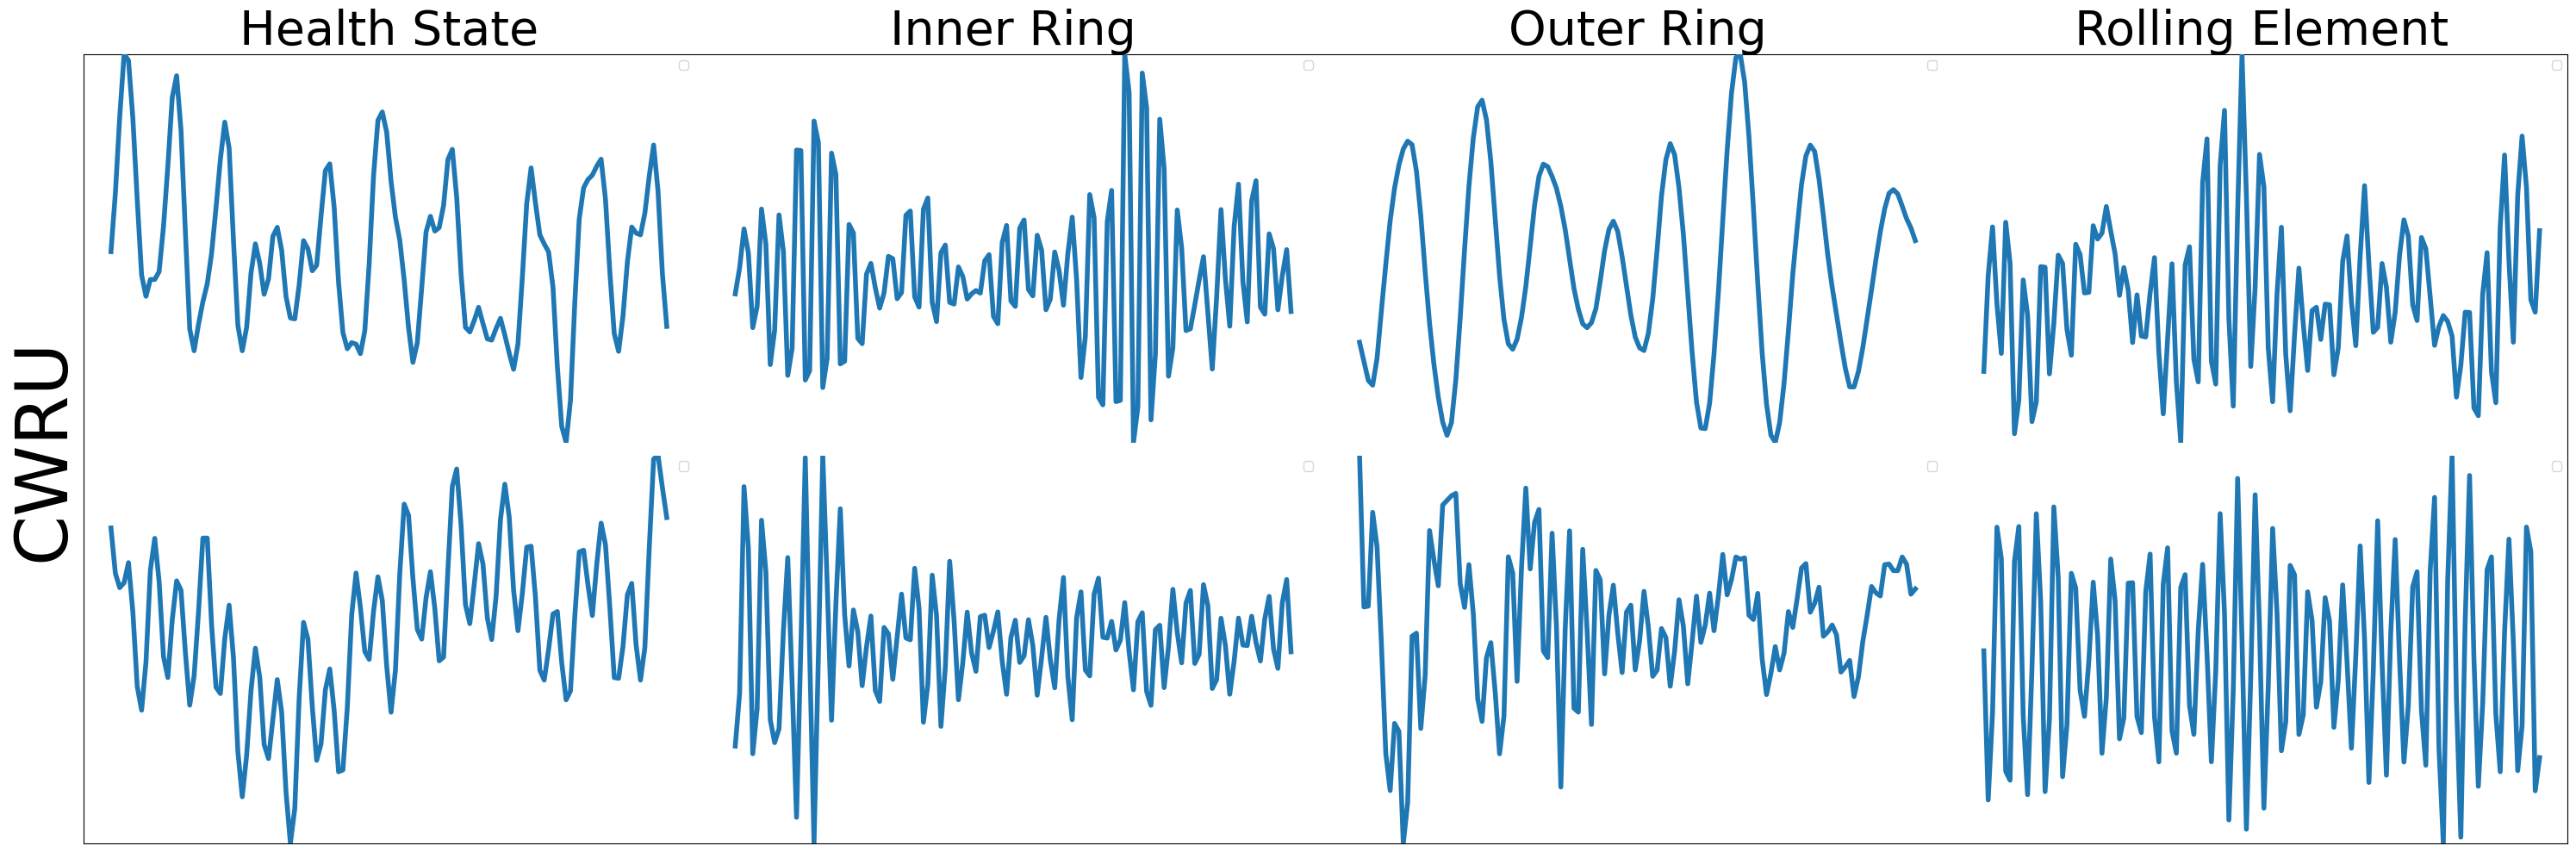

In [1118]:
def plot_signals(series_temporales, labels):
    """
    Dibuja los clusters con una cuadrícula de 3 columnas y N filas.

    Args:
        series_temporales (numpy.ndarray): Array de series temporales.
        labels (numpy.ndarray): Etiquetas de los clusters.
        centroids (numpy.ndarray): Centroides de los clusters.
        n_clusters (int): Número de clusters.
    """
    # Determinar el número de filas y columnas
    n_cols = 4
    n_rows = int(np.ceil(series_temporales.shape[0] / n_cols))

    fig = plt.figure(figsize=(30, n_rows * 5))  # Ajustar tamaño según filas

    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel("CWRU", fontsize=60)
    
    for index,(s, label) in enumerate(zip(series_temporales, labels)):
        ax = plt.subplot(n_rows, n_cols, index+1)  # Configurar subplot
        
        if index < n_cols:
            ax.set_title(' '.join([l.capitalize() for l in label.split()]), fontsize=40)
        ax.plot(s, linewidth=4)
        
        #plt.title(f"Cluster {cluster_idx}")
        ax.set_ylim(0, 1)
        ax.legend(loc="upper right")
        ax.set_axis_off()
        #plt.grid(True)

    plt.tight_layout()
    

signals = []
labels = []
for _ in range(2):
    for l in [3, 0, 1, 2]:
        i = np.random.choice(np.where(Y_train == l)[0])
        signals.append(X_train[i])
        labels.append(task.meta['target_labels'][int(l)])
    
plot_signals(np.array(signals), ['health state', 'inner ring', 'outer ring', 'rolling element']+['health state', 'inner ring', 'outer ring', 'rolling element'])
plt.savefig('CWRU_samples.pdf')